
<div align="right" style="text-align:right"><i>Peter Norvig<br>May 2020</i></div>

# Flipping Cards: A Guessing Game

The [538 Riddler for Aug. 17, 2018](
https://fivethirtyeight.com/features/step-1-game-theory-step-2-step-3-profit/) poses this problem:

> Take a standard deck of cards, and pull out the numbered cards from one suit (the nine cards 2 through 10). Shuffle them, and then lay them face down in a row. Flip over the first card so it is face up. Now guess whether the next card in the row (the first down card) is higher or lower. If you’re right, keep going. If you play this game optimally, what’s the probability that you can get to the end without making any mistakes?<p>
> *Extra credit:* What if there were more cards — 2 through 20, or 2 through 100? How do your chances of getting to the end change?
    
First, let's define "*play this game optimally.*"  The optimal policy is to look at the current flipped-up card and, remembering what cards have already been flipped and thus knowing what cards remain face-down, guess that the first down card will be "higher" if the majority of the down cards are higher than the up card, otherwise guess that it will be "lower".  (*Details*: In case of a tie in the counts, guessing either "higher" or "lower" is equally optimal. When there are only two cards left (one up, one down) you know for sure what the down card is, so you can always guess right.)
    
# Brute Force Algorithm
    
We can solve the problem with brute force: for every permutation of the cards, call `guess_all` to determine if the optimal policy guesses right on that sequence of cards.  Assuming every permutation is equally likely (that is, the cards were shuffled fairly), the overall probability of guessing right is the proportion of `True` results.
    
> *Python Trivia*: `True` is equal to `1` and `False` is equal to `0`, so `sum([True, False, True])` is 2; `mean([True, False, True])` is 2/3, and when `b` is a Boolean and `x` is a number, the expression `(b and x)` is equivalent to `(x if b else 0)` and the expression `(x - b)` is equivalent to `((x - 1) if b else x)`. In other languages you would be required (or at least encouraged) to explicitly cast Booleans to integers, but in Python `bool` is a subclass of `int` and it is considered good style to do without casts.
    
I can implement `guess_all` as follows:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from itertools  import permutations
from statistics import mean
from functools  import lru_cache

In [2]:
def guess_all(cards) -> bool: 
    """You guess all the cards right if you guess the first right and the rest right."""
    return len(cards) <= 2 or guess_first(cards) and guess_all(cards[1:])

def guess_first(cards) -> bool:
    """Guess that the first down card will be "higher" or "lower" according to majority 
    counts of the down cards; return True if the guess is correct."""
    up, *down = cards
    higher = sum(d > up for d in down)
    lower  = sum(d < up for d in down)
    return (higher > lower) == (down[0] > up)

Some simple examples:

In [3]:
# On this sequence, the optimal policy always guesses "higher"; 
# and it turns out that's always right.  
guess_all((2, 3, 4, 5, 6))

True

In [4]:
# On this sequence, the optimal policy guesses "higher" first; that's wrong.
# There is a 3/4 chance that a down card is higher than 3, but it turns
# out that the first down card, 2, is the one lower card.
guess_all((3, 2, 4, 5, 6)) 

False

In [5]:
guess_first((3, 2, 4, 5, 6))

False

# The Answer

The probability that we can guess all nine cards right is the average over all possible permutations of the cards:

In [6]:
cards = "🃂🃃🃄🃅🃆🃇🃈🃉🃊" # Use Unicode cards instead of boring ints; why not?
answer = mean(map(guess_all, permutations(cards)))
answer

0.17085537918871252

That's the correct answer ([per 538](https://fivethirtyeight.com/features/how-many-hoops-will-kids-jump-through-to-play-rock-paper-scissors/)): about 17% chance of guessing all nine cards right.
____


# Extra Credit: Efficient Algorithm

The extra credit problem asks about 19 and 99 cards. But there are $19! \approx 10^{17}$ permutations of 19 cards and a whopping $99! \approx 10^{156}$ permutations of 99 cards. So my brute force algorithm won't work. 

(*Note*: since we are now dealing with the general case of $n$ cards, I'll represent them as `range(n)`, that is, starting at `0` rather than `2`.)

# Efficient Algorithm: Analysis

We will need a more efficient way of representing cards, so that we don't need to consider $n!$ possibilities. I see two ideas that will help. Consider what happens when we are deciding whether to guess "higher" or "lower" in `guess_first(cards)`: 

**First**, the **order** of the `down` cards doesn't matter. The optimal policy makes the same guess whether `down` is `(2, 3, 4, 5)` or a permutation such as `(4, 2, 5, 3)`. So we could represent cards as a set: `{2, 3, 4, 5}`. As we discard flipped cards, we must consider subsets. Since there are $n!$ permutations but only $2^n$ subsets of $n$ cards, this is a nice improvement, good enough to handle $n=19$ (but not good enough for $n=99$).

**Second**, the **identity** of the `down` cards doesn't matter. What does matter is how many down cards are higher or lower than the up card. For example, when the up card is `3` it doesn't matter if the remaining cards are `{2, 3, 6}` or `{1, 3, 4}` or `{0, 3, 5}` or any other set of three cards in which the `3` is the middle card. For any such set, there is one card higher and one card lower than the up card, so the chance of guessing right is 50%. Note that I can't  represent all these situations as "*there are 3 cards remaining and the up card is 3*" but I can represent them as  "*there are 3 cards remaining and the up card is the second lowest*". 

In other words, I can describe the up card by **renumbering** it to be its index into the sorted list of remaining cards (up and down). For each of the three sets described here, the index of the `3` card is `1`; it is the second element of the sorted list of cards:

In [7]:
for cards in ({2, 3, 6}, {1, 3, 4}, {0, 3, 5}):
    assert sorted(cards).index(3) == 1

Some further examples of renumbering:

  - [Cards: `{2, 3, 6}` Up: `3`] *renumbered to* [Cards: `range(3)` Up: `1`] (i.e., second lowest)
  - [Cards: `{1, 3, 4}` Up: `3`] *renumbered to* [Cards: `range(3)` Up: `1`] (i.e., second lowest)
  - [Cards: `{0, 3, 5}` Up: `3`] *renumbered to* [Cards: `range(3)` Up: `1`] (i.e., second lowest)
  - [Cards: `{3, 5, 7}` Up: `3`] *renumbered to* [Cards: `range(3)` Up: `0`] (i.e., lowest)
  - [Cards: `{0, 1, 3}` Up: `3`] *renumbered to* [Cards: `range(3)` Up: `2`] (i.e., third lowest)

  
Now I can describe any situation with just two integers, the number of cards and the index of the up card. That means there are only $n^2$ possible situations to describe, which should be good enough to handle $n=99$ and beyond. 

What I have done is gone from a **concrete** representation of the cards as explicit permutations to an **abstract** representation that says how many cards remain and what the index number of the up card is, but doesn't say exactly what the cards are nor what order they are in. This kind of abstraction is often a good way to fight against combinatorial explosion.




# Efficient Algorithm: First Try

I wanted to define a function, `P_all(n)`, that tells me the probability of guessing all `n` cards right. I wrote down a first try at a definition:

    def P_all(n) -> float:
        return 1 if n <= 2 else P_first(n) * P_all(n - 1)
        
Could it really be as simple as that? All I have to do is define `P_first(n)` (the probability of guessing the first of `n` cards right) and I'm done? My immediate reaction was that this feels *too* easy. I was suspicious of this definition for three reasons:

1. It is rare (but not unheard of) for an efficient algorithm to be simpler than the brute force algorithm.
- I said there should be renumbering, but this code doesn't do any renumbering.
- This code says the joint probability of getting the first card right and then getting the rest right is the product of their probabilities. But that's true *only when the two events are independent*. And in flipping cards, the two events are *not* independent, because both events depend on the card that is the first down card in `P_first(n)` and becomes the up card in `P_all(n - 1)`. 

My suspicions were well-founded: this code won't work.

# Efficient Algorithm: Second Try

I need to capture the fact that the card that is the first down card for the current guess becomes the up card for the next guess.  One way to do that is to define `P_all_given(up, n)` to be the probability of guessing all the cards right given that the flipped-up card has index `up` in the sorted list of `n` remaining cards (including the `up` card).

Now `P_all(n)` is defined to call `P_all_given(up, n)` for each possible `up` card and average the results:

In [8]:
def P_all(n) -> float:
    """Probability of guessing all n cards right."""
    return mean(P_all_given(up, n) for up in range(n))

`P_all_given(up, n)` works by considering each possible first down card (`down1`), computing if we would guess the first down card right given the up card  (`guess_first_given(up, down1, n)`), and if right, calling `P_all_given` recursively with the old first down card (renumbered) being the new up card, and the deck size, `n`, being one card smaller. 
When this is all done, we take the average probability value over all the down cards. We also arrange for `P_all_given` to cache its values so that we don't repeat computations; this is crucial for efficiency.

In [9]:
@lru_cache(None)
def P_all_given(up, n) -> float:
    """Probability of guessing all n cards right, given the index of the up card."""
    return (1 if n <= 2 else
            mean(guess_first_given(up, down1, n) and P_all_given(renumber(down1, up), n - 1)
                 for down1 in range(n) if down1 != up))

The function `guess_first_given(up, down1, n)`, defined below, returns true if we would correctly guess the first down card given the up card. The optimal policy is to guess that the first down card will be higher than the renumbered up card when the up card is in the lower half of `range(n)`. 

And finally, `renumber` renumbers a card by decrementing it by one if the card we are discarding (the up card) is lower (meaning that the card we are keeping becomes one closer to the lowest possible card). Otherwise the card's number is unchanged.

In [10]:
def guess_first_given(up, down1, n) -> bool:
    """Do we guess the first down card right given the up card, 
    when the set of cards (including up and down) is range(n)?"""
    return (up < n / 2) == (down1 > up)

def renumber(card, discard) -> int:  return card - (discard < card)

We can see that `P_all(n)` agrees with the brute-force answer  (except for round-off in the 17th decimal place):

In [11]:
print(P_all(9))
print(answer)

0.17085537918871255
0.17085537918871252


# The Extra Credit Answers

We can now efficiently answer the extra credit questions:

In [12]:
P_all(19)

0.008419397002884993

In [13]:
P_all(99)

6.67213407124781e-14

The moral is: give yourself at least about 100 tries to guess 19 cards right, and don't expect to *ever* guess 99 cards right.

# Closed Form Formula?

I would like to come up with a closed-form formula for `P_all(n)` as a function of $n$. I don't see how to define an *exact* formula, but I can see that:
- When the up card is the very middle of the remaining cards, we have a 50% chance of guessing the next card  right.
- When the up card is the very highest or very lowest of the remaining cards, we have a 100% chance of guessing the next card right.
- So on average (very roughly speaking), we should have about a 75% chance of guessing right on each card.
- In a full deck we make $n - 2$ guesses (we don't have to guess the first card, and we will know the last card for sure).
- Therefore, the chance of guessing all the cards right is  roughly $0.75^{(n-2)}$

If the exponential formula  $0.75^{(n-2)}$ were correct, then it would be true that `P_all(n + 1) / P_all(n) = 0.75` for all `n`. Let's sample some values of `n` and see:

In [14]:
Ns = [*range(2, 10), *range(19, 99, 20), *range(99, 400, 100)]

{n: P_all(n + 1) / P_all(n) 
 for n in Ns}

{2: 0.8333333333333334,
 3: 0.8,
 4: 0.775,
 5: 0.7688172043010753,
 6: 0.7587412587412588,
 7: 0.7557603686635944,
 8: 0.7500967866821525,
 9: 0.7483290322580645,
 19: 0.7343228066190575,
 39: 0.7277139939871775,
 59: 0.7255656153885536,
 79: 0.7245013548920631,
 99: 0.7238659386192225,
 199: 0.7226021071682432,
 299: 0.7221828896968574,
 399: 0.7219736649122889}

We see that the ratio starts higher than 0.75 and becomes lower. That means that `P_all(n)` is not exactly an exponential function.

How close is it?  Let's draw a plot to see. We'll use a log scale, on which an exponential is a straight (blue) line. I use 0.725 as the base for the exponential, which nicely highlights that the `P_all(n)` data points (red) start out and end up on the blue exponential line, but rise slightly above it in the middle. Still the points are a very good fit to the line, considering that they span 56 orders of magnitude. I also show the line for `0.75 ** (n - 2)`; all the data points except the first few are well below that.

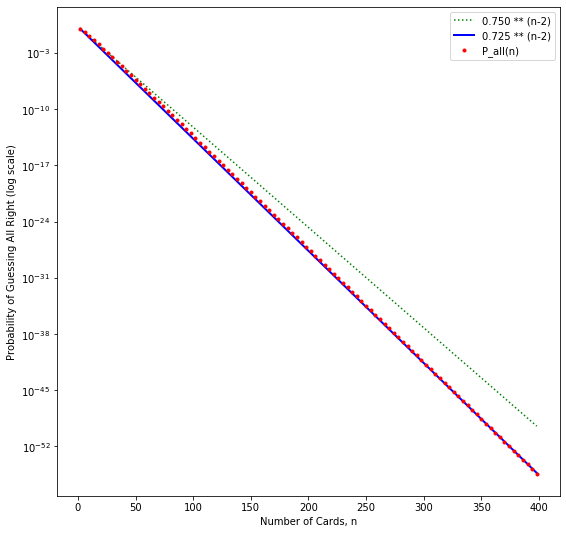

In [15]:
base = 0.725

X = range(2, 400, 4)
P = [P_all(n)        for n in X]
E = [base ** (n - 2) for n in X]
G = [0.75 ** (n - 2) for n in X]

plt.figure(figsize=(9, 9))
plt.yscale('log')
plt.xlabel("Number of Cards, n")
plt.ylabel("Probability of Guessing All Right (log scale)")
plt.plot(X, G, 'g:', label='0.750 ** (n-2)')
plt.plot(X, E, 'b-', lw=2, label=f'{base} ** (n-2)')
plt.plot(X, P, 'r.', label='P_all(n)')
plt.legend();

# Computational Complexity: O(n) Notation 

The brute force algorithm, with `guess_all(n)`, requires $O(n!)$ computation time because it considers every permutation of $n$ cards.

In the efficient algorithm,  `P_all(n)` makes $n$ calls to `P_all_given`, and each call to `P_all_given` considers $n$ down cards and makes  recursive calls only when `guess_first_given(up, down1, n)` returns true. Some of those calls have already been computed and are cached. It seems complicated to do an exact analysis. 

However, if we assume that the majority of the work done by `P_all` is inside a call to `P_all_given`,  and note that both of `P_all_given`'s arguments are restricted to $n$ possible values, then we can conclude that only $O(n^2)$ unique calls can be made. Repeated calls will fetch results from the cache in constant time. Therefore `P_all` is $O(n^2)$.

Experimental evidence shows that for every value of `n` tested so far, a call to `P_all(n)` does *exactly* $n \times (n + 1) / 2 - 1$ unique calls to `P_all_given`. We can determine this by looking at the number of elements in the function's cache.

In the table below, `n` is the number of cards,  `s` is the size of the cache, and we see that `s` is always equal to $c = n \times (n + 1) / 2 - 1$. 

The last four columns of the table don't deal with computational complexity. They give the value of `P_all(n)`, the ratio `P_all(n + 1) / P_all(n)`, the approximation  `base ** (n - 2)`, and the percentage difference between the true value and the approximation.

In [16]:
P_all_given.cache_clear()

print(f'   n |      s | s==c ||P_all(n) |P(n+1)/P(n)|base**(n-2)| Δ(P, {base}**(n-2))')
print(f'—————|————————|——————||—————————|———————————|———————————|——————————————————')
for n in Ns:
    p = P_all(n)
    s = P_all_given.cache_info().currsize
    c = n * (n + 1) / 2 - 1
    e = base ** (n - 2)
    r = P_all(n + 1) / P_all(n)
    Δ = (p - e) / p
    print(f'{n:4d} | {s:6,d} | {s == c} ||{p:8.1e} |   {r:6.4f}  | {e:8.1e}  | {Δ:3.0%}')

   n |      s | s==c ||P_all(n) |P(n+1)/P(n)|base**(n-2)| Δ(P, 0.725**(n-2))
—————|————————|——————||—————————|———————————|———————————|——————————————————
   2 |      2 | True || 1.0e+00 |   0.8333  |  1.0e+00  |  0%
   3 |      5 | True || 8.3e-01 |   0.8000  |  7.2e-01  | 13%
   4 |      9 | True || 6.7e-01 |   0.7750  |  5.3e-01  | 21%
   5 |     14 | True || 5.2e-01 |   0.7688  |  3.8e-01  | 26%
   6 |     20 | True || 4.0e-01 |   0.7587  |  2.8e-01  | 30%
   7 |     27 | True || 3.0e-01 |   0.7558  |  2.0e-01  | 34%
   8 |     35 | True || 2.3e-01 |   0.7501  |  1.5e-01  | 36%
   9 |     44 | True || 1.7e-01 |   0.7483  |  1.1e-01  | 38%
  19 |    189 | True || 8.4e-03 |   0.7343  |  4.2e-03  | 50%
  39 |    779 | True || 1.6e-05 |   0.7277  |  6.8e-06  | 57%
  59 |  1,769 | True || 2.6e-08 |   0.7256  |  1.1e-08  | 58%
  79 |  3,159 | True || 4.2e-11 |   0.7245  |  1.8e-11  | 58%
  99 |  4,949 | True || 6.7e-14 |   0.7239  |  2.8e-14  | 57%
 199 | 19,899 | True || 5.5e-28 |   0.722